In [50]:
import torch
import torch.optim as optim
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [52]:
output_dir = os.getcwd() + "\\DummyOutputs"
os.makedirs(output_dir, exist_ok=True)

In [53]:
def export_tensor_to_csv_numpy(tensor, filename,device=device):
    if device == device:
        array = tensor.detach().cpu().numpy()
    else:
        array = tensor.cpu().detach().numpy()
    
    # Ensure the array is of floating-point type
    if not np.issubdtype(array.dtype, np.floating):
        array = array.astype(np.float64)
    
    # Save with double precision and '.' as decimal delimiter
    np.savetxt(filename, array, delimiter=',', fmt='%.15f')
    print(f"Exported tensor to {filename} using NumPy with double precision.")

In [54]:
# Define the parameters to optimize (these come from your original model)
params = {
    'pa': torch.tensor(0.5, requires_grad=True, device= device),
    'pb': torch.tensor(0.8, requires_grad=True, device=device),
    'pe': torch.tensor(2.6,requires_grad=True,device=device),
    'ph': torch.tensor(1.0,requires_grad=True,device=device),
    'alpha':torch.tensor(1.0,requires_grad=True,device=device),
    'd': torch.tensor(30.0, requires_grad=True, device=device),
    'pc': torch.tensor(0.16, requires_grad=True, device=device),
    'substrate_val': torch.tensor(0.3, requires_grad=True, device= device),
    'dt': torch.tensor(1e-1, requires_grad=True, device=device),
    'gamma': torch.tensor(625.0, requires_grad=True, device=device),
    'pk': torch.tensor(0.05, requires_grad=True, device=device),
    'lap_side': torch.tensor(0.35,requires_grad=True, device=device),
    'lap_diag': torch.tensor(0.1,requires_grad=True, device=device),
    'lap': torch.tensor(1/9,requires_grad=True,device=device),
    'amax': torch.tensor(30.0,requires_grad=True,device=device),
    'smax': torch.tensor(3e20,requires_grad=True,device=device),
    'threshold': torch.tensor(0.5,requires_grad=True,device=device),
    'depth': torch.tensor(2.0,requires_grad=True,device=device),
    'Dn': torch.tensor(0.1,requires_grad=True,device=device),
    'consumption_rate': torch.tensor(0.002,requires_grad=True,device=device)
}

Dimensions of the bipolar image: (245, 245)


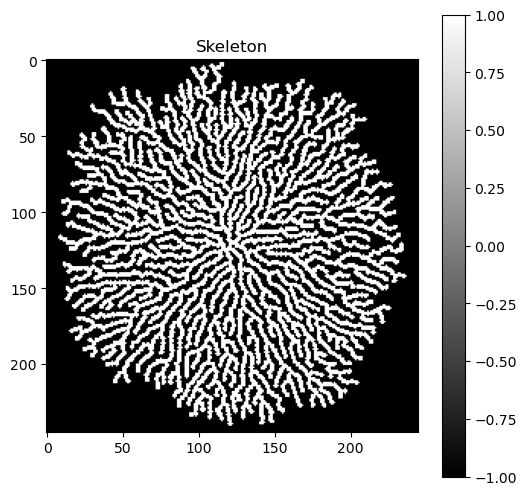

In [55]:
import os

# Step 1: Load the RGB image
image_path = os.getcwd() + "\\Mycelium_model_real_image.png"
rgb_image = mpimg.imread(image_path)

# Step 2: Use only the first channel for simplicity
first_channel = rgb_image[:, :, 0]  # Extract the first channel
threshold = 0.5
skeleton = np.where(first_channel < threshold, 1, -1)  # Create bipolar image directly

# Step 3: Extract dimensions
dimensions = skeleton.shape
print(f"Dimensions of the bipolar image: {dimensions}")

# Step 4: Plot the bipolar image
plt.figure(figsize=(6, 6))
plt.title('Skeleton')
plt.imshow(skeleton, cmap='gray')
plt.colorbar()
plt.show()

In [56]:
# Hyperparameters
grid_size = 500 #skeleton.shape[0]
total_iterations = 500

In [57]:
# Initialize activator, suppressor, and mycelium matrices as PyTorch tensors
u = torch.zeros((grid_size, grid_size), device=device)
v = torch.zeros((grid_size, grid_size), device=device)
c = torch.zeros((grid_size, grid_size), device=device)

u_new = torch.zeros_like(u)
v_new = torch.zeros_like(v)
c_new = torch.zeros_like(c)

# Initialize nutrient landscape
mid = grid_size // 2
# n = torch.ones((grid_size, grid_size), device=device)
# n[:, mid:] = 0.3

# Nutrient landscape with nutrient islands
n = torch.ones((grid_size, grid_size), device=device) * 0.0  # Low baseline nutrient level
#n[:, mid:] = 0.08
num_islands = 30  # Number of nutrient islands
island_radius = 10  # Radius of nutrient islands
high_nutrient_value = 0.9# Nutrient level inside islands

# Rocks (obstacles) on substrate that spawn randomly
num_rocks = 50
rock_radius = 15  # Radius of each rock
#torch.manual_seed(torch.initial_seed())  # Ensure different rocks each run

for _ in range(num_islands):
    # Random center for each island
    center_x = torch.randint(island_radius, grid_size - island_radius, (1,)).item()
    center_y = torch.randint(island_radius, grid_size - island_radius, (1,)).item()

    for i in range(grid_size):
        for j in range(grid_size):
            if (i - center_x)**2 + (j - center_y)**2 <= island_radius**2:
                n[i, j] = high_nutrient_value  # Set higher nutrient value inside the island


# uncomment to inlude rocks in the simulation
# for _ in range(num_rocks):
#     # Random center for each rock
#     rock_x = torch.randint(rock_radius, grid_size - rock_radius, (1,)).item()
#     rock_y = torch.randint(rock_radius, grid_size - rock_radius, (1,)).item()

#     for i in range(grid_size):
#         for j in range(grid_size):
#             if (i - rock_x)**2 + (j - rock_y)**2 <= rock_radius**2:
#                 n[i, j] = 0  # Rocks prevent growth by setting nutrient level to zero

# Step 2: Apply the skeleton mask
#n[skeleton < 0.0] = -1.0
#print(mid)

print(n.shape)
print(u.shape)
print(v.shape)
print(c.shape)


torch.Size([500, 500])
torch.Size([500, 500])
torch.Size([500, 500])
torch.Size([500, 500])


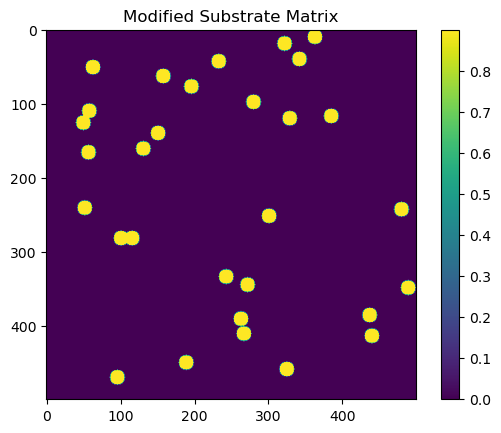

C:\Users\georg\AppData\Local\Temp\ipykernel_26172\662640312.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n = torch.tensor(n, dtype=torch.float32, device=device)


In [58]:
plt.imshow(n.cpu().detach().numpy(), cmap='viridis')  # Using viridis for better color distinction
plt.colorbar()
plt.title("Modified Substrate Matrix")
plt.show()

n = torch.tensor(n, dtype=torch.float32, device=device)

In [59]:
# Initialize matrices
u = torch.zeros((grid_size, grid_size), device=device)
v = torch.zeros((grid_size, grid_size), device=device)
c = torch.zeros((grid_size, grid_size), device=device)

# Initial activator and suppressor states
for k in range(-6, 5):  # This ranges from -5 to 5, inclusive
    size = 2 * abs(k) + 1  # This computes the size of the square
    start_idx = mid + k if k < 0 else mid - k
    if start_idx + size <= grid_size:  # Check to ensure indices are within bounds
        random_tensor = torch.rand((size, size), device=device) * 0.5 
        # u[start_idx:start_idx+size, start_idx:start_idx+size] = 0.5 + random_tensor / (0.5 * n[start_idx:start_idx+size, start_idx:start_idx+size])
        # v[start_idx:start_idx+size, start_idx:start_idx+size] = 0.1 + random_tensor / (0.5 * n[start_idx:start_idx+size, start_idx:start_idx+size])
        # c[start_idx:start_idx+size, start_idx:start_idx+size] = 1
        u[start_idx:start_idx+size, start_idx:start_idx+size] = 0.5 + 0.2
        v[start_idx:start_idx+size, start_idx:start_idx+size] = 0.1 + 0.2 
        c[start_idx:start_idx+size, start_idx:start_idx+size] = 1.0

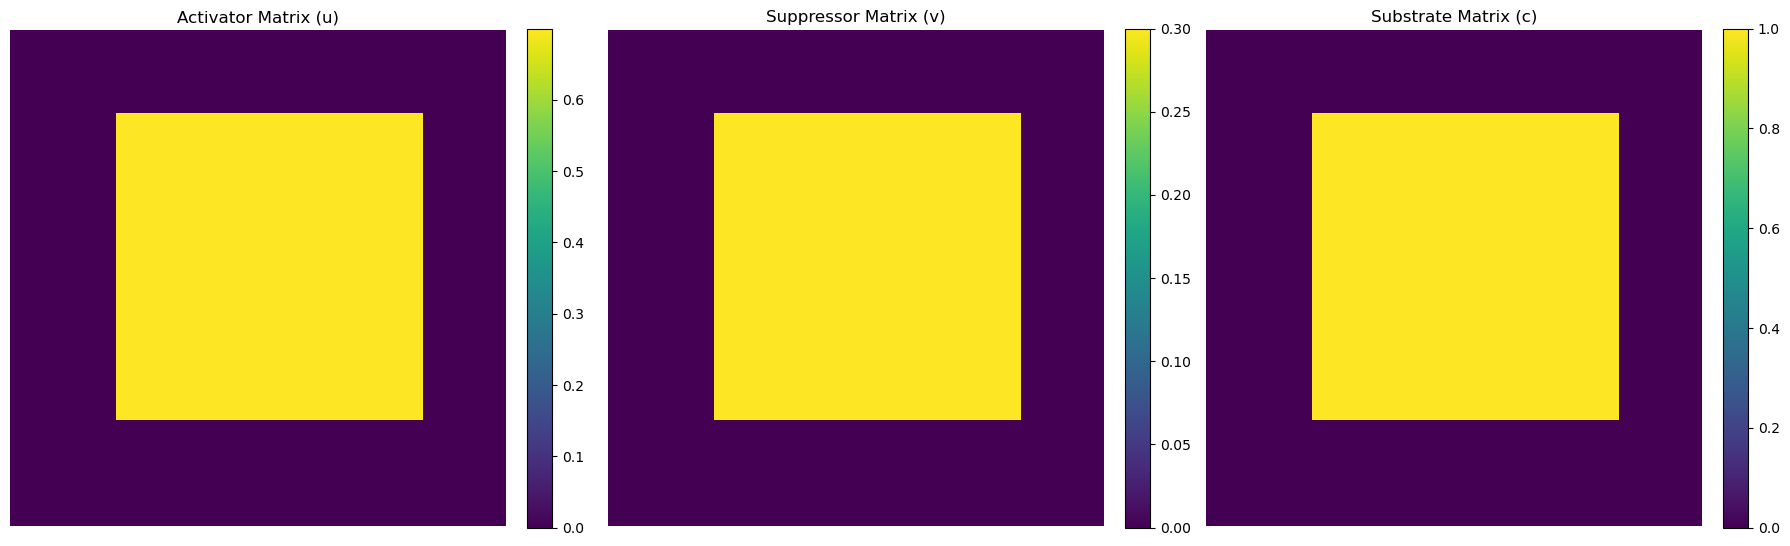

In [60]:
# Assuming 'u', 'v', and 'c' are PyTorch tensors and have been processed appropriately.
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Wider figure to accommodate colorbars

# Define limits for zooming into the center
x_limits = (mid-11, mid+10)
y_limits = (mid-11, mid+10)

# Plot u matrix
im_u = axs[0].imshow(u.cpu().numpy(), cmap='viridis')
axs[0].set_title('Activator Matrix (u)')
axs[0].axis('off')
axs[0].set_xlim(x_limits)
axs[0].set_ylim(y_limits)
fig.colorbar(im_u, ax=axs[0], fraction=0.046, pad=0.04)  # Add colorbar to the plot of u

# Plot v matrix
im_v = axs[1].imshow(v.cpu().numpy(), cmap='viridis')
axs[1].set_title('Suppressor Matrix (v)')
axs[1].axis('off')
axs[1].set_xlim(x_limits)
axs[1].set_ylim(y_limits)
fig.colorbar(im_v, ax=axs[1], fraction=0.046, pad=0.04)  # Add colorbar to the plot of v

# Plot c matrix
im_c = axs[2].imshow(c.cpu().numpy(), cmap='viridis')
axs[2].set_title('Substrate Matrix (c)')
axs[2].axis('off')
axs[2].set_xlim(x_limits)
axs[2].set_ylim(y_limits)
fig.colorbar(im_c, ax=axs[2], fraction=0.046, pad=0.04)  # Add colorbar to the plot of c

plt.tight_layout()
plt.show()


In [61]:
# Define filenames with step number
filename_c = os.path.join(output_dir, f'c_init.csv')
filename_u = os.path.join(output_dir, f'u_init.csv')
filename_v = os.path.join(output_dir, f'v_init.csv')
filename_n = os.path.join(output_dir, f'n_init.csv')

# Export tensors to CSV using NumPy
export_tensor_to_csv_numpy(c, filename_c)
export_tensor_to_csv_numpy(u, filename_u)
export_tensor_to_csv_numpy(v, filename_v)
export_tensor_to_csv_numpy(n, filename_n)

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\c_init.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\u_init.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\v_init.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\n_init.csv using NumPy with double precision.


In [62]:
def update_visualization(step, u, v, c, n):
    fig = plt.figure(figsize=(15, 15))
    
    # Activator u
    ax1 = fig.add_subplot(221)
    img1 = ax1.imshow(u.cpu().detach().numpy(), cmap='jet', vmin=0, vmax=params['amax'].cpu().detach().numpy())
    ax1.set_title(f'Activator u at iteration {step}')
    fig.colorbar(img1, ax=ax1)  # Add colorbar for this subplot

    # Suppressor v
    ax2 = fig.add_subplot(222)
    img2 = ax2.imshow(v.cpu().detach().numpy(), cmap='jet', vmin=0, vmax=params['smax'].cpu().detach().numpy())
    ax2.set_title(f'Suppressor v at iteration {step}')
    fig.colorbar(img2, ax=ax2)  # Add colorbar for this subplot

    # Mycelium c
    ax3 = fig.add_subplot(223)
    img3 = ax3.imshow(c.cpu().detach().numpy(), cmap='jet', vmin=-1, vmax=1)
    ax3.set_title(f'Mycelium at iteration {step}')
    fig.colorbar(img3, ax=ax3)  # Add colorbar for this subplot

    # Substrate n
    ax4 = fig.add_subplot(224)
    img4 = ax4.imshow(n.cpu().detach().numpy(), cmap='jet')
    ax4.set_title('Substrate')
    fig.colorbar(img4, ax=ax4)  # Add colorbar for this subplot

    plt.tight_layout()
    plt.show()

In [63]:
# Laplacian (Diffusion) Kernel Weights
lap_side = params['lap_side']
lap_diag = params['lap_diag']
lap = params['lap']

# Depth (Size) of Kernel
depth = params['depth']

# Plasma Membrane of Mycelium
ij_mat = torch.zeros((grid_size, grid_size), device=device)

In [64]:
def calculate_same_padding(input_size, kernel):
    """
    Calculate the padding needed to keep the output size the same as the input size.
    
    Args:
    - input_size (tuple): A tuple representing the height and width of the input tensor (e.g., (245, 245)).
    - kernel_size (tuple): A tuple representing the height and width of the kernel (e.g., (3, 3)).
    
    Returns:
    - padding (tuple): A tuple representing the padding for height and width.
    """
    kernel_height = kernel.shape[2]  # Height of the kernel
    kernel_width = kernel.shape[3]   # Width of the kernel
    
    # Calculate the padding for height and width
    padding_height = (kernel_height - 1) // 2
    padding_width = (kernel_width - 1) // 2
    
    return (padding_height, padding_width)

In [65]:
def lap_kernel_calc(depth,lap,lap_side,lap_diag):
    depth = int(depth.cpu().detach().numpy())
    lap = lap.detach()
    lap_side = lap_side.detach()
    lap_diag = lap_diag.detach()
    lap_kernel = torch.zeros((2*depth+1, 2*depth+1)).to(device)
    for dx in range(-depth, depth + 1):
        for dy in range(-depth, depth + 1):
            if dx == 0 and dy == 0:
                lap_kernel[depth, depth] = lap
            elif abs(dx) == abs(dy):
                lap_kernel[depth + dx, depth + dy] = lap_diag
            else:
                lap_kernel[depth + dx, depth + dy] = lap_side

    print(lap_kernel)
    print(lap_kernel.shape)

    repeat_factor = grid_size // 5
    D = lap_kernel.repeat(repeat_factor, repeat_factor)



    #print(f"D shape: {D.shape}")  # Should be (grid_size, grid_size)
    return lap_kernel, D

In [66]:
lap_kernel_calc(depth,lap,lap_side,lap_diag)

tensor([[0.1000, 0.3500, 0.3500, 0.3500, 0.1000],
        [0.3500, 0.1000, 0.3500, 0.1000, 0.3500],
        [0.3500, 0.3500, 0.1111, 0.3500, 0.3500],
        [0.3500, 0.1000, 0.3500, 0.1000, 0.3500],
        [0.1000, 0.3500, 0.3500, 0.3500, 0.1000]], device='cuda:0')
torch.Size([5, 5])


(tensor([[0.1000, 0.3500, 0.3500, 0.3500, 0.1000],
         [0.3500, 0.1000, 0.3500, 0.1000, 0.3500],
         [0.3500, 0.3500, 0.1111, 0.3500, 0.3500],
         [0.3500, 0.1000, 0.3500, 0.1000, 0.3500],
         [0.1000, 0.3500, 0.3500, 0.3500, 0.1000]], device='cuda:0'),
 tensor([[0.1000, 0.3500, 0.3500,  ..., 0.3500, 0.3500, 0.1000],
         [0.3500, 0.1000, 0.3500,  ..., 0.3500, 0.1000, 0.3500],
         [0.3500, 0.3500, 0.1111,  ..., 0.1111, 0.3500, 0.3500],
         ...,
         [0.3500, 0.3500, 0.1111,  ..., 0.1111, 0.3500, 0.3500],
         [0.3500, 0.1000, 0.3500,  ..., 0.3500, 0.1000, 0.3500],
         [0.1000, 0.3500, 0.3500,  ..., 0.3500, 0.3500, 0.1000]],
        device='cuda:0'))

In [67]:
# Define the 3x3 Laplacian kernel L
L = torch.tensor([
    [lap_diag, lap_side, lap_diag],
    [lap_side, -lap,     lap_side],
    [lap_diag, lap_side, lap_diag]
], dtype=torch.float32, device=device)

print(L)

tensor([[ 0.1000,  0.3500,  0.1000],
        [ 0.3500, -0.1111,  0.3500],
        [ 0.1000,  0.3500,  0.1000]], device='cuda:0')


In [68]:
def conv2_same(input_tensor, kernel):
    """
    Performs a 2D convolution with 'same' padding.
    
    Args:
        input_tensor (torch.Tensor): Input tensor of shape [H, W].
        kernel (torch.Tensor): Convolution kernel of shape [kH, kW] or [1, 1, kH, kW].
    
    Returns:
        torch.Tensor: Convolved tensor of shape [H, W].
    """
    # Ensure the kernel has 4 dimensions
    if kernel.dim() == 2:
        kernel = kernel.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, kH, kW]
    elif kernel.dim() == 4:
        pass  # Already in the correct shape
    else:
        raise ValueError("Kernel must be a 2D or 4D tensor.")
    
    # Extract input tensor dimensions
    H, W = input_tensor.shape
    
    # Calculate padding for 'same' convolution based on input size and kernel size
    pad_h, pad_w = calculate_same_padding((H, W), kernel)
    
    # Reshape input to [N, C, H, W]
    input_reshaped = input_tensor.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]
    
    # Perform convolution with calculated padding
    conv_result = F.conv2d(input_reshaped, kernel, padding=(pad_h, pad_w))
    
    # Reshape back to [H, W]
    return conv_result.squeeze(0).squeeze(0)

In [84]:
def CA_simulation(u, v, c, n, params, total_iterations, grid_size, output_dir):
    # Unpack the parameters
    pa = params['pa'] 
    pb = params['pb'] 
    pe = params['pe'] 
    d = params['d'] 
    gamma = params['gamma'] 
    dt = params['dt'] 
    ph = params['ph'] 
    amax = params['amax'] 
    smax=params['smax'] 
    threshold = params['threshold'] 
    depth =params['depth']
    alpha = params['alpha']
    ph = params['ph']
    amax = params['amax']
    Dn = params['Dn']
    consumption_rate = params['consumption_rate']
    
    
    lap_kernel, D = lap_kernel_calc(depth,params['lap'],params['lap_side'],params['lap_diag'])
    epsilon = 1e-03

    #noise_u = torch.randint(1, 11, u.size(), device=device).float() / 10000
    #noise_c = torch.randint(1, 1001, c.size(), device=device).float() / 10000
    
    noise_u = torch.randint_like(u,1,11,requires_grad=True,device=device)/10000
    noise_c = torch.randint_like(c,1,1001,requires_grad=True,device=device)/10000

    ones_kernel = torch.ones((1, 1, lap_kernel.shape[0], lap_kernel.shape[1]), dtype=torch.float32, device=device)

    # Main simulation loop
    with torch.no_grad(): #ADDING TORCH.NO_GRAD() IS IMPERATIVE
        for step in range(total_iterations + 1):
            # Reaction Terms
            f_uv = (pa * u + u ** 2 - pb * u * v) * n
            g_uv = pe * u - v -1

            # Calculate ij_mat - the plasma membrane in which the mycelium can expand each iteration
            c_positive = (c > 0).float()
            input_tensor = c_positive.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, grid_size, grid_size]
            
            #print(f'c size: {c_positive.size()}')
            #print(f'ones kernel size: {ones_kernel.size()}')
            
            #padding = calculate_same_padding(input_tensor,ones_kernel)
            conv_result = F.conv2d(input_tensor, ones_kernel, padding=int(depth.item()))
            conv_result = conv_result.squeeze(0).squeeze(0)  # Shape: [grid_size, grid_size]
            #print(f'conv_result: {conv_result.size()}')
            #print(f'depth: {int(depth.cpu().detach().numpy())}')
            
            conv_min = torch.minimum(conv_result, torch.ones_like(conv_result))
            #print(conv_min.size())
        
            ij_mat = torch.mul(conv_min, D)
        

            # Compute v_new and u_new
            conv_v = conv2_same(v, L)  # Assuming conv2_same is defined elsewhere
            term_v = d * conv_v + gamma * g_uv
            update_v = ij_mat * term_v
            v_new = v + dt * update_v

            conv_u = conv2_same(u, L)  # Assuming conv2_same is defined elsewhere
            term_u = conv_u + gamma * f_uv
            update_u = ij_mat * term_u
            u_new = u + dt * update_u

            # Apply threshold and adjust alpha
            u_new = torch.where(n == -1, u - noise_u, u_new)
            alpha = torch.where(u <= threshold, 0.49, 0.49 - 2.5 * (u - threshold))
            v_new = torch.where(u <= threshold, v_new, 0.0) # What is that?
    

            # Update c using alpha and apply limits
            c_new = c + dt * gamma * ph * c * (alpha - c) * (c - 1)
            c_new = torch.where(alpha < 0, c + noise_c, c_new)

            # Limiters of activator and suppressor to avoid exponential growth
            # Limiters of activator and suppressor to avoid exponential growth
            u_new = torch.clamp(u_new, min=0.0, max=amax.item())
            v_new = torch.where(v_new > smax, smax, v_new)
            c_new = torch.where(c_new > 1, 1, c_new)
            c_new = torch.where(c_new < 0, c + noise_c, c_new)
            c_new = torch.where(c_new == 1, c - noise_c, c_new)
            c_new = torch.where(c_new > 1, 1, c_new)
            
            #Compute Laplacian for nutrient matrix 'n' to simulate diffusion
            conv_n = conv2_same(n,L)
            diffusion_n = Dn*conv_n
            
            n_new = n+dt*diffusion_n
            n_new = torch.clamp(n_new, min=0.0, max=0.9)
            
            # Update variables
            u, v, c, n = u_new, v_new, c_new, n_new
            
            if torch.isnan(u).any():
                print(f"NaN values found at step {step} -- Tensor u")
                break
            elif torch.isnan(v).any():
                print(f"NaN values found at step {step} -- Tensor v")
                break
            elif torch.isnan(c).any():
                print(f"NaN values found at step {step} -- Tensor c")
                break

            # Visualization every 100 steps
            if step % 100 == 0:
                # Define filenames with step number
                filename_c = os.path.join(output_dir, f'c_step_{step}.csv')
                filename_u = os.path.join(output_dir, f'u_step_{step}.csv')
                filename_v = os.path.join(output_dir, f'v_step_{step}.csv')
                filename_n = os.path.join(output_dir, f'n_step_{step}.csv')

                # Export tensors to CSV
                export_tensor_to_csv_numpy(c, filename_c)
                export_tensor_to_csv_numpy(u, filename_u)
                export_tensor_to_csv_numpy(v, filename_v)
                export_tensor_to_csv_numpy(n, filename_n)

                # Update visualization
                update_visualization(step, u, v, c, n)

    # Return the final state variables
    return u, v, c, n

tensor([[0.1000, 0.3500, 0.3500, 0.3500, 0.1000],
        [0.3500, 0.1000, 0.3500, 0.1000, 0.3500],
        [0.3500, 0.3500, 0.1111, 0.3500, 0.3500],
        [0.3500, 0.1000, 0.3500, 0.1000, 0.3500],
        [0.1000, 0.3500, 0.3500, 0.3500, 0.1000]], device='cuda:0')
torch.Size([5, 5])
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\c_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\u_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\v_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\n_step_0.csv using NumPy with double precision.


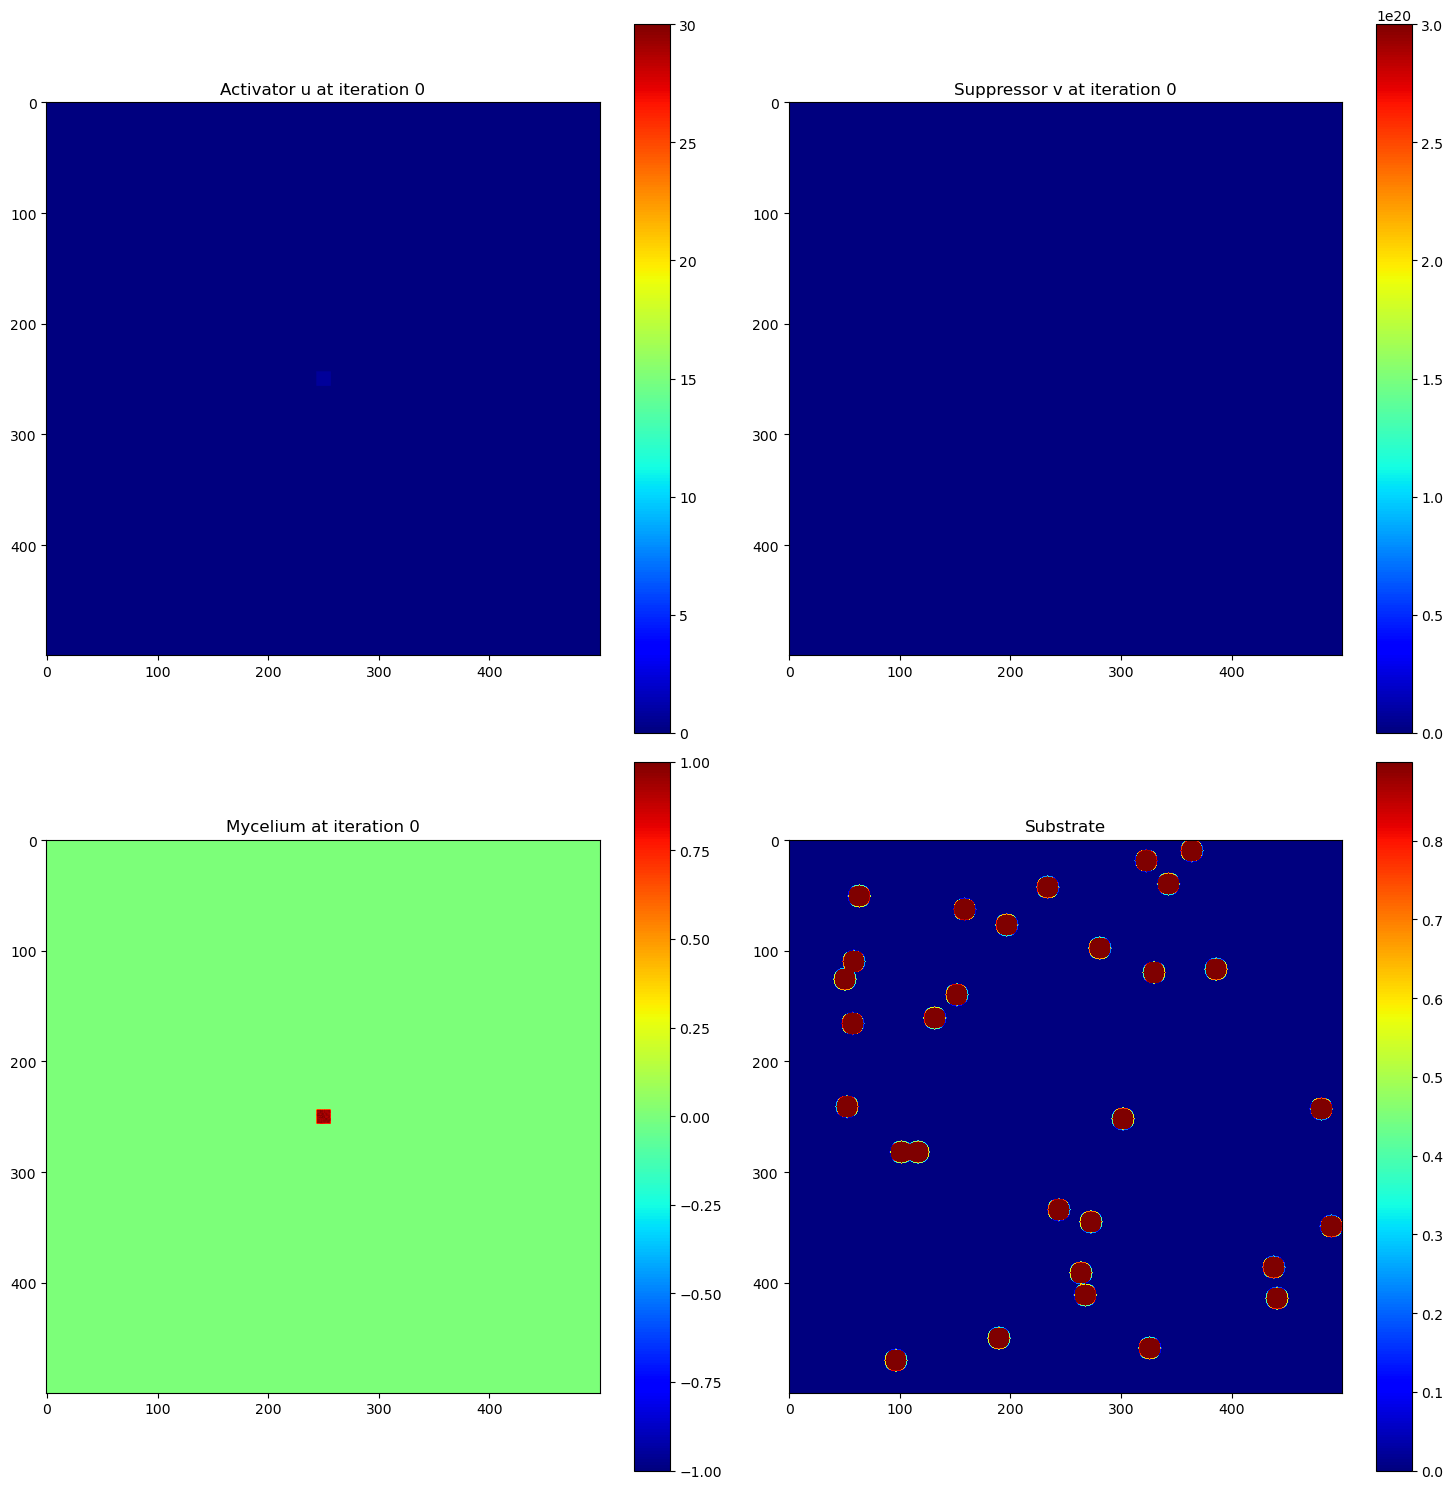

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\c_step_100.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\u_step_100.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\v_step_100.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\n_step_100.csv using NumPy with double precision.


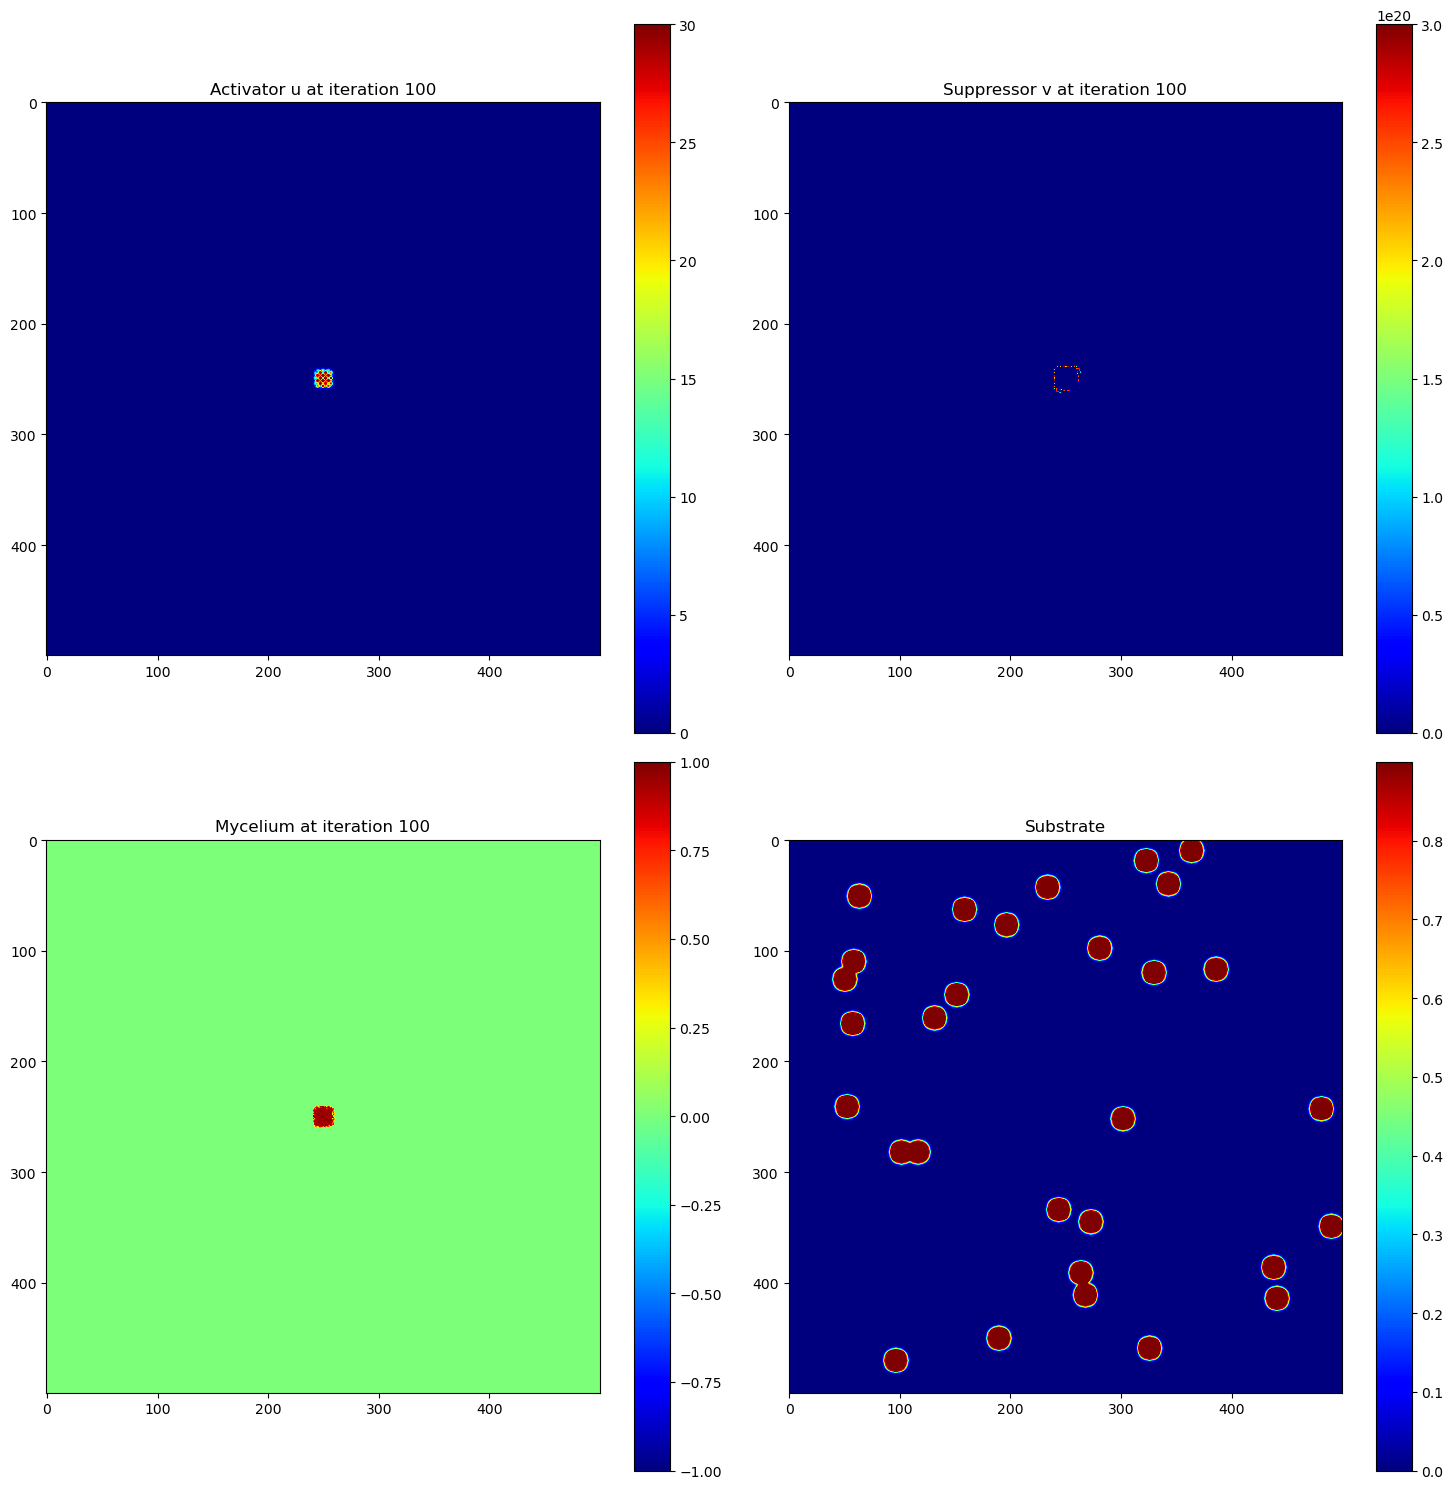

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\c_step_200.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\u_step_200.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\v_step_200.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\n_step_200.csv using NumPy with double precision.


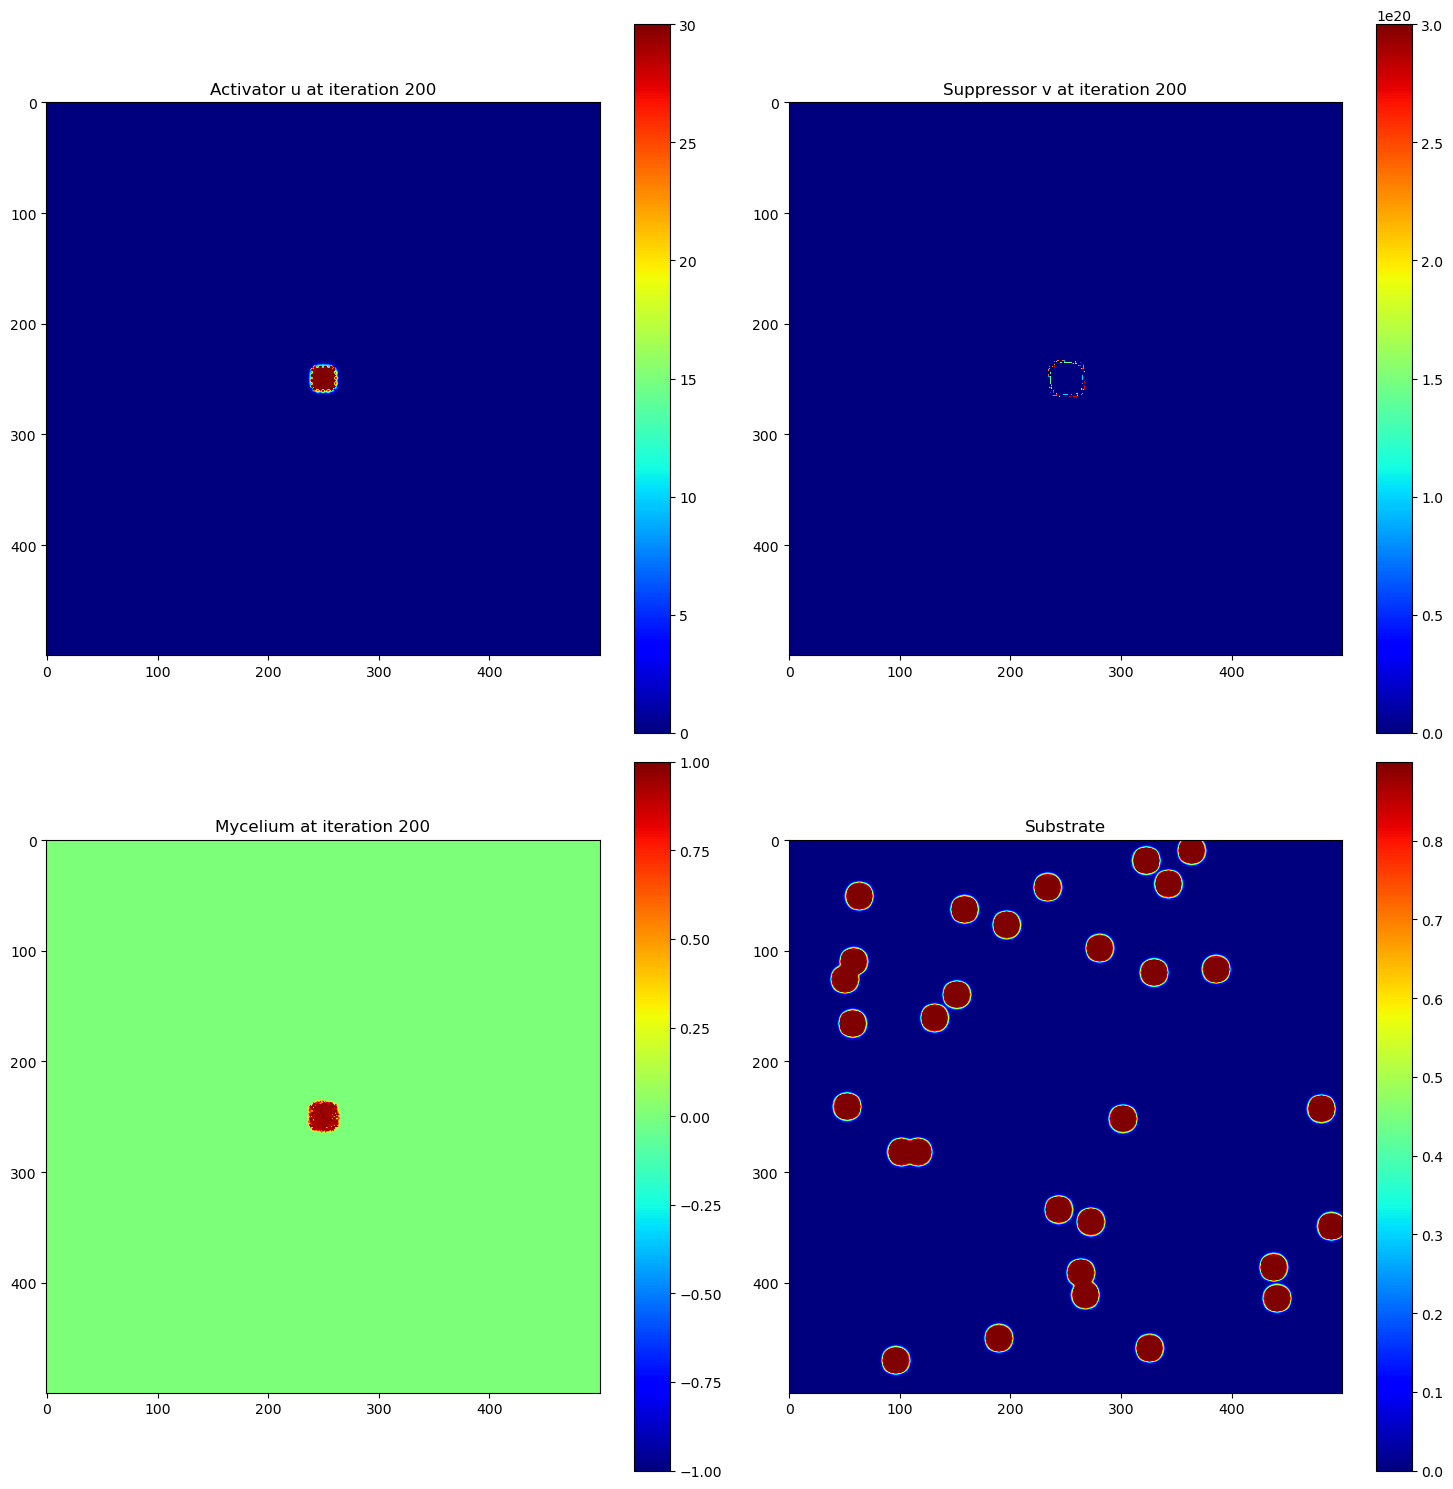

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\c_step_300.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\u_step_300.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\v_step_300.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\n_step_300.csv using NumPy with double precision.


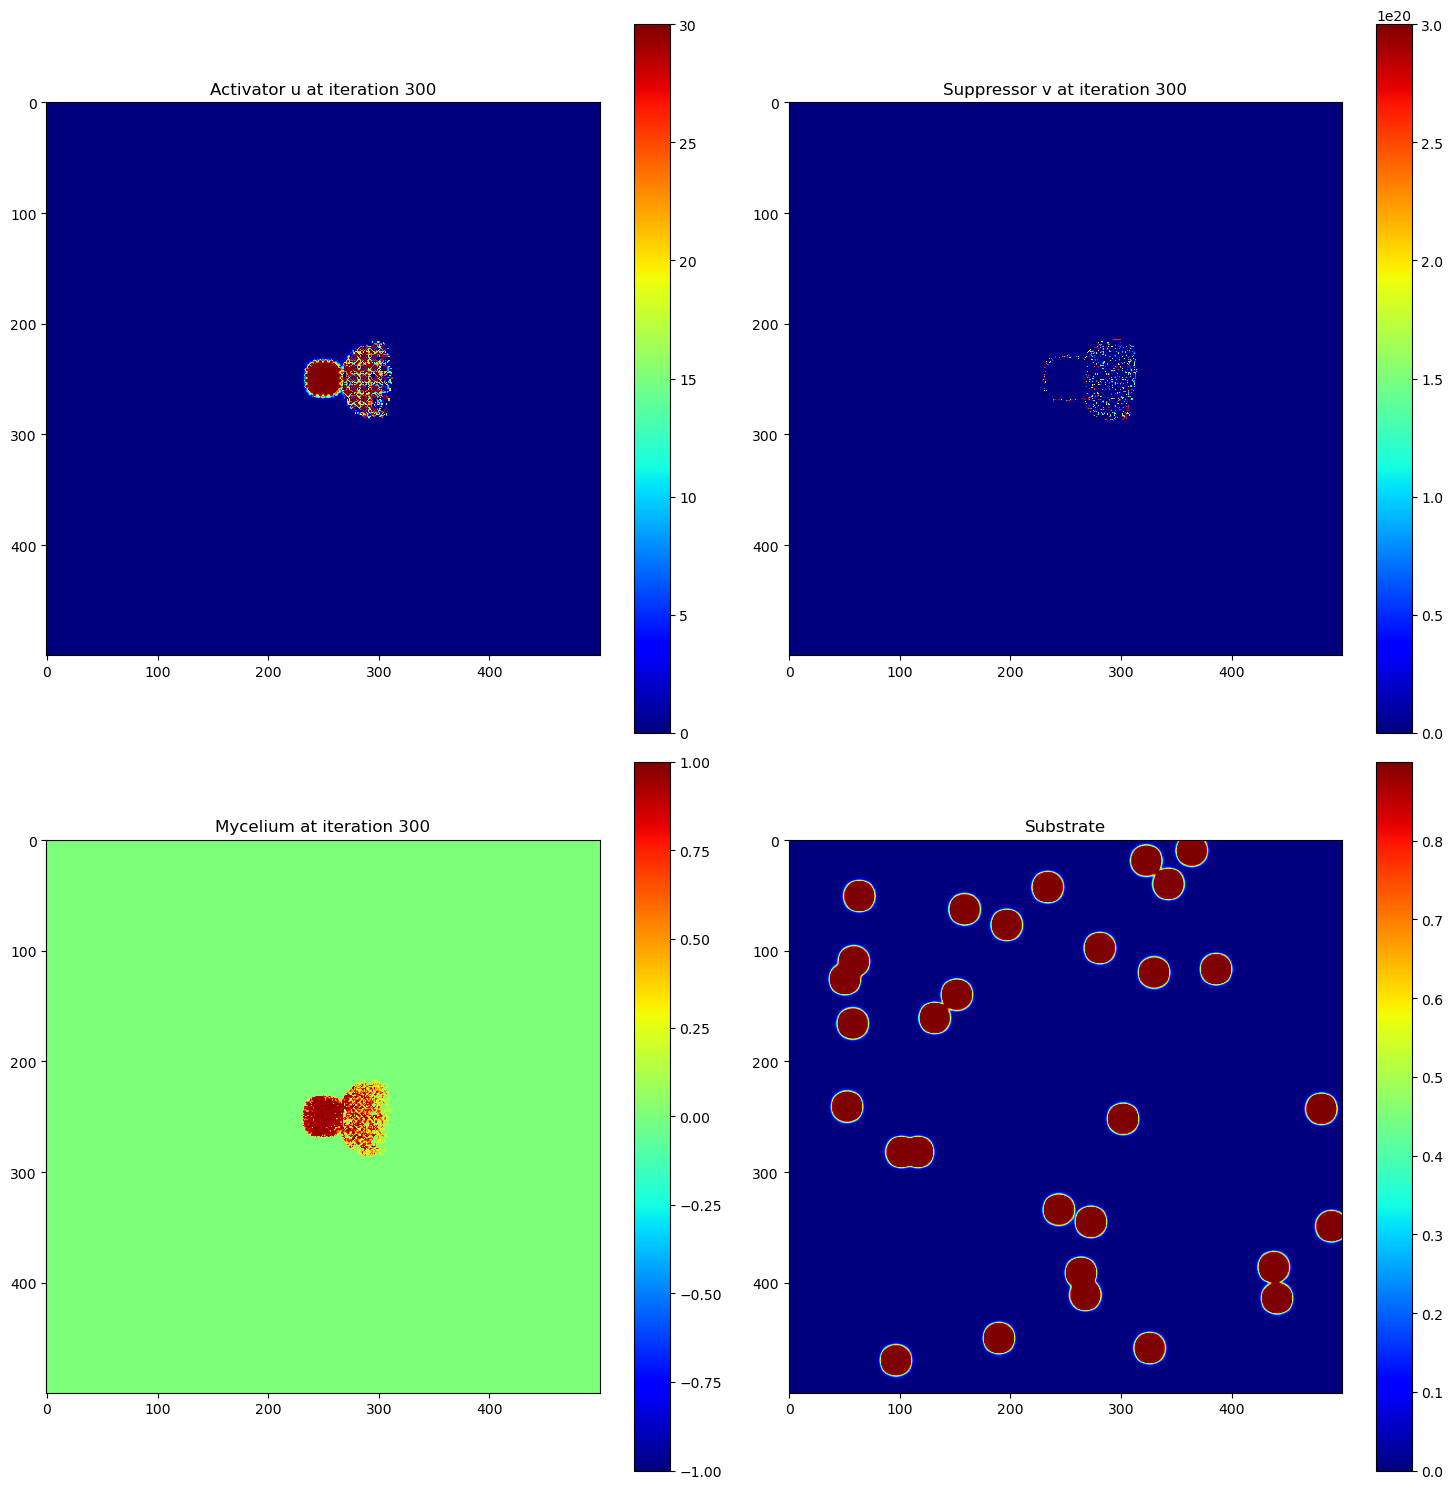

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\c_step_400.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\u_step_400.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\v_step_400.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\n_step_400.csv using NumPy with double precision.


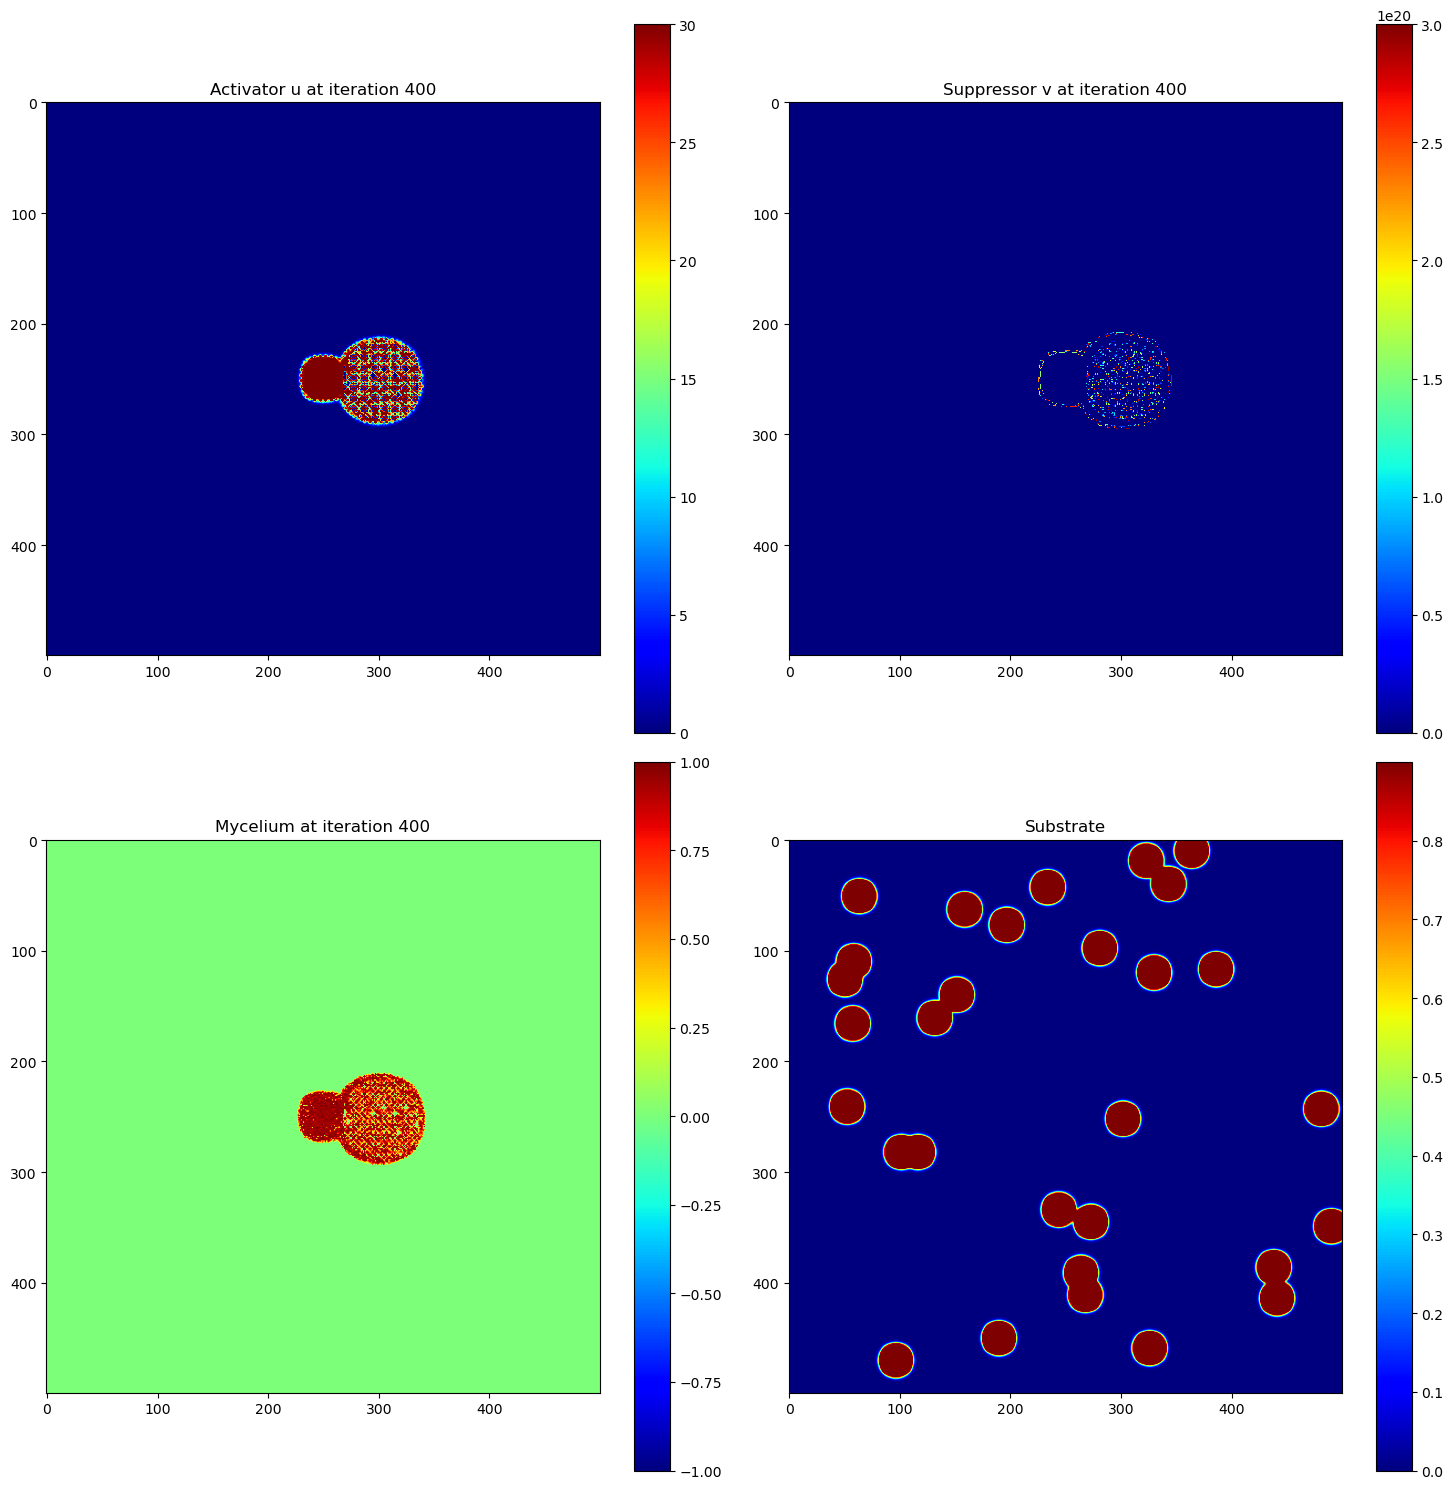

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\c_step_500.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\u_step_500.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\v_step_500.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\n_step_500.csv using NumPy with double precision.


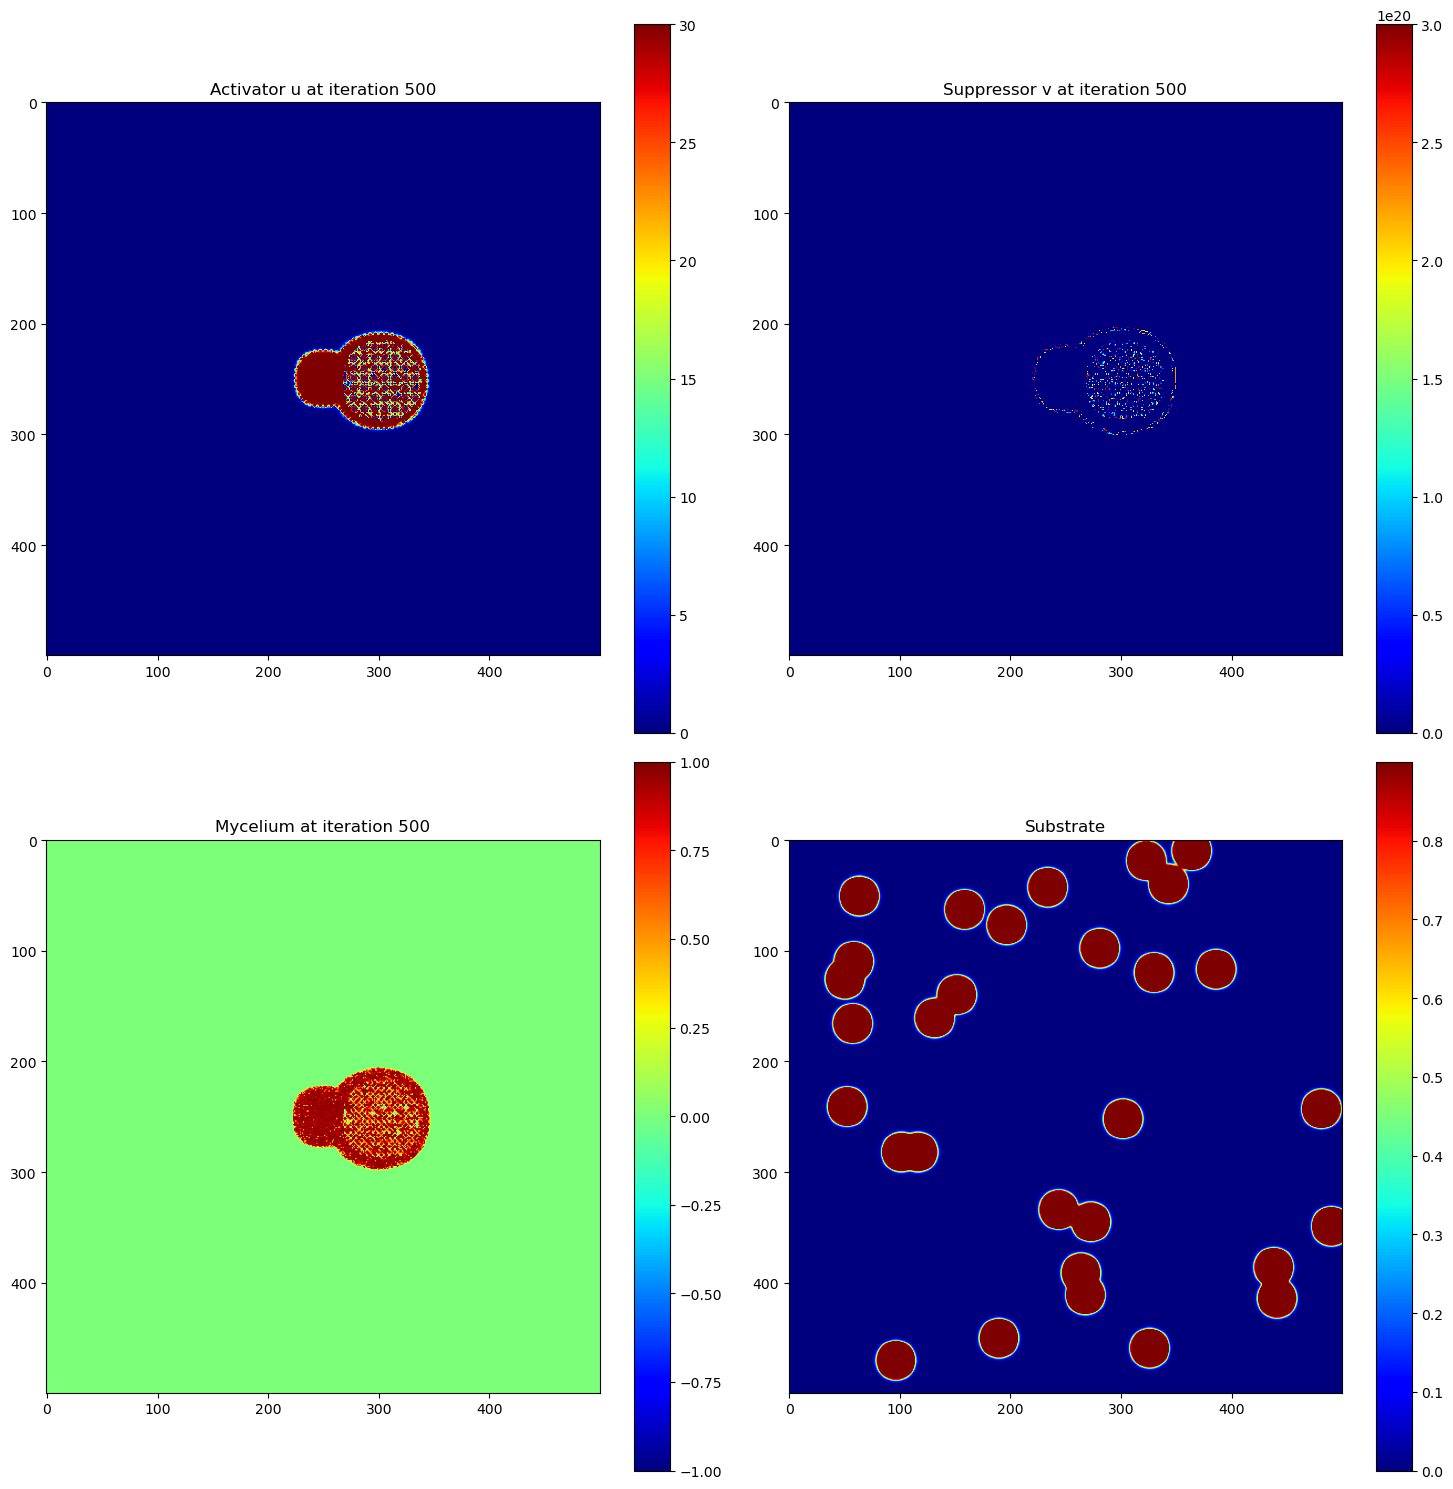

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\c_step_600.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\u_step_600.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\v_step_600.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\n_step_600.csv using NumPy with double precision.


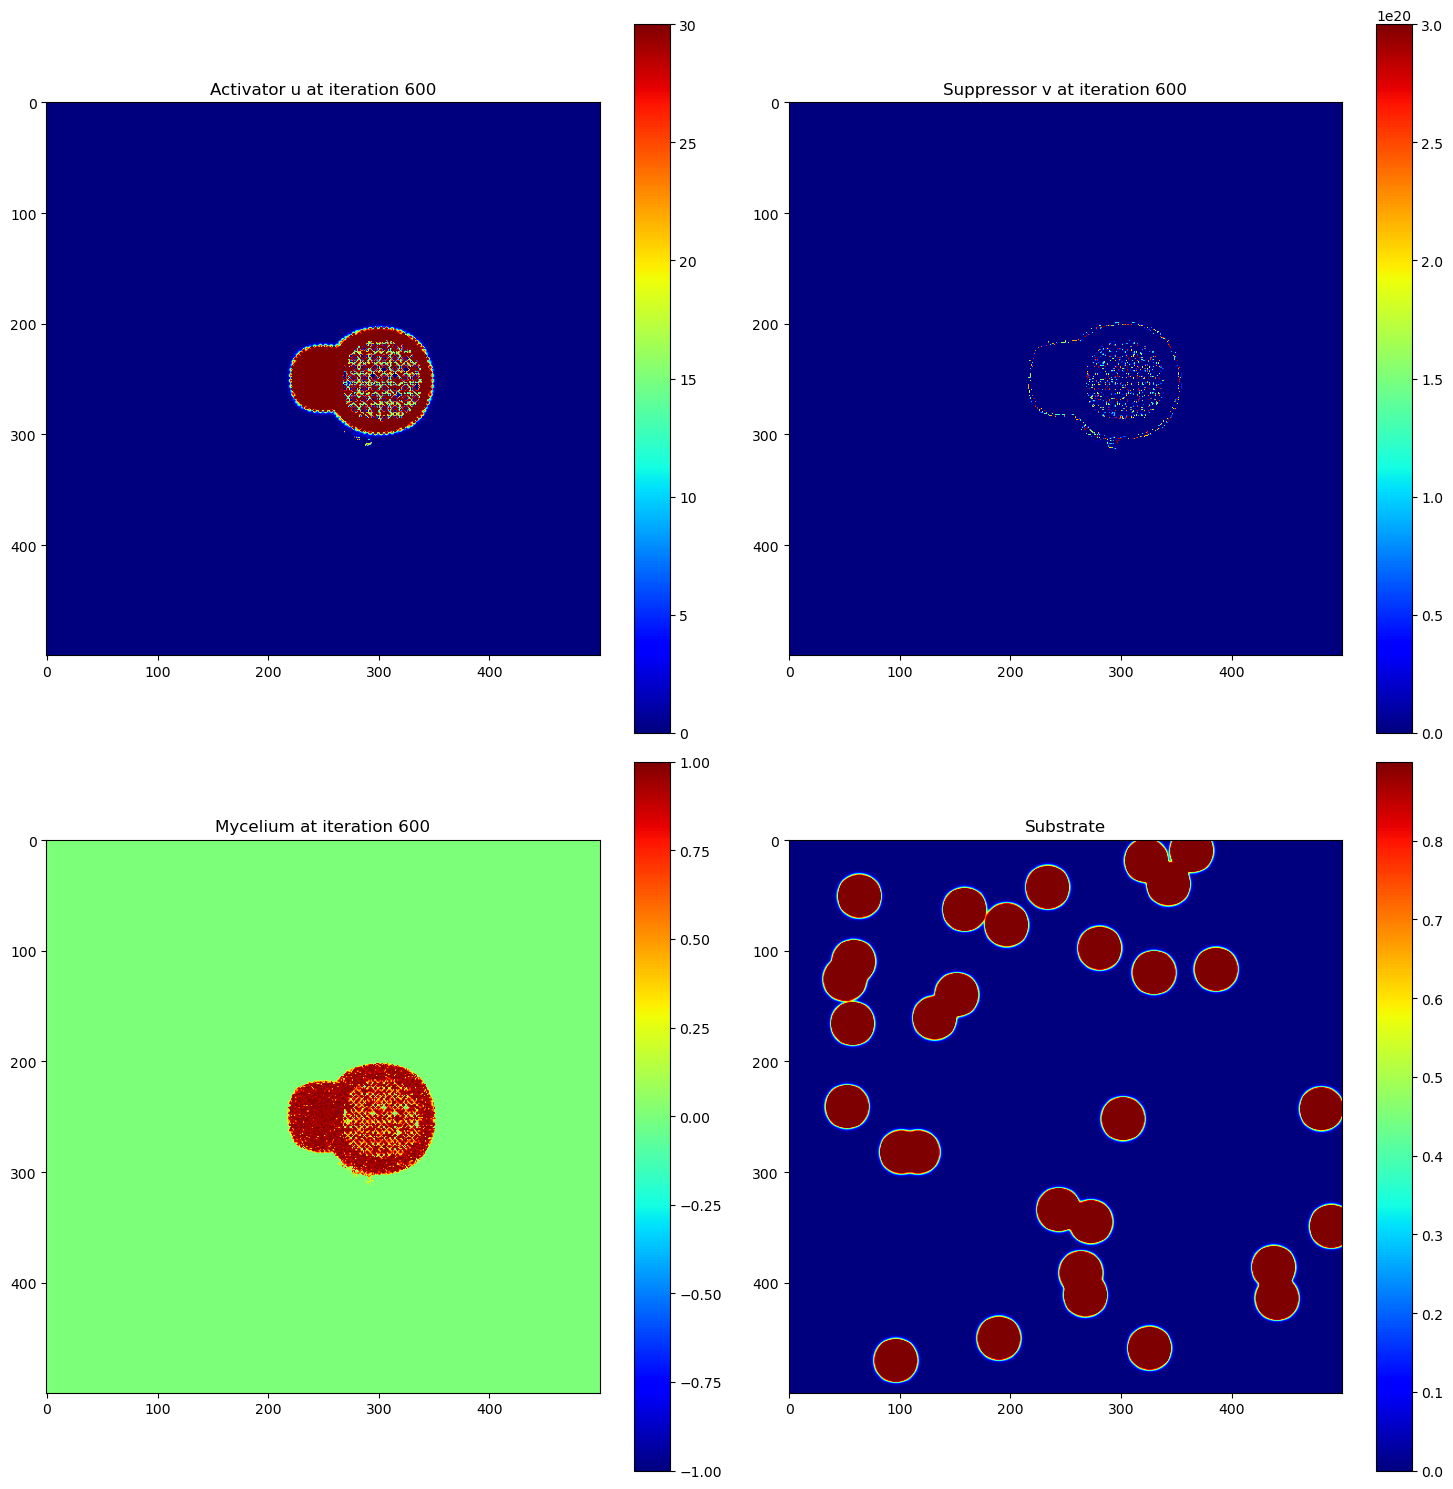

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\c_step_700.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\u_step_700.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\v_step_700.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\n_step_700.csv using NumPy with double precision.


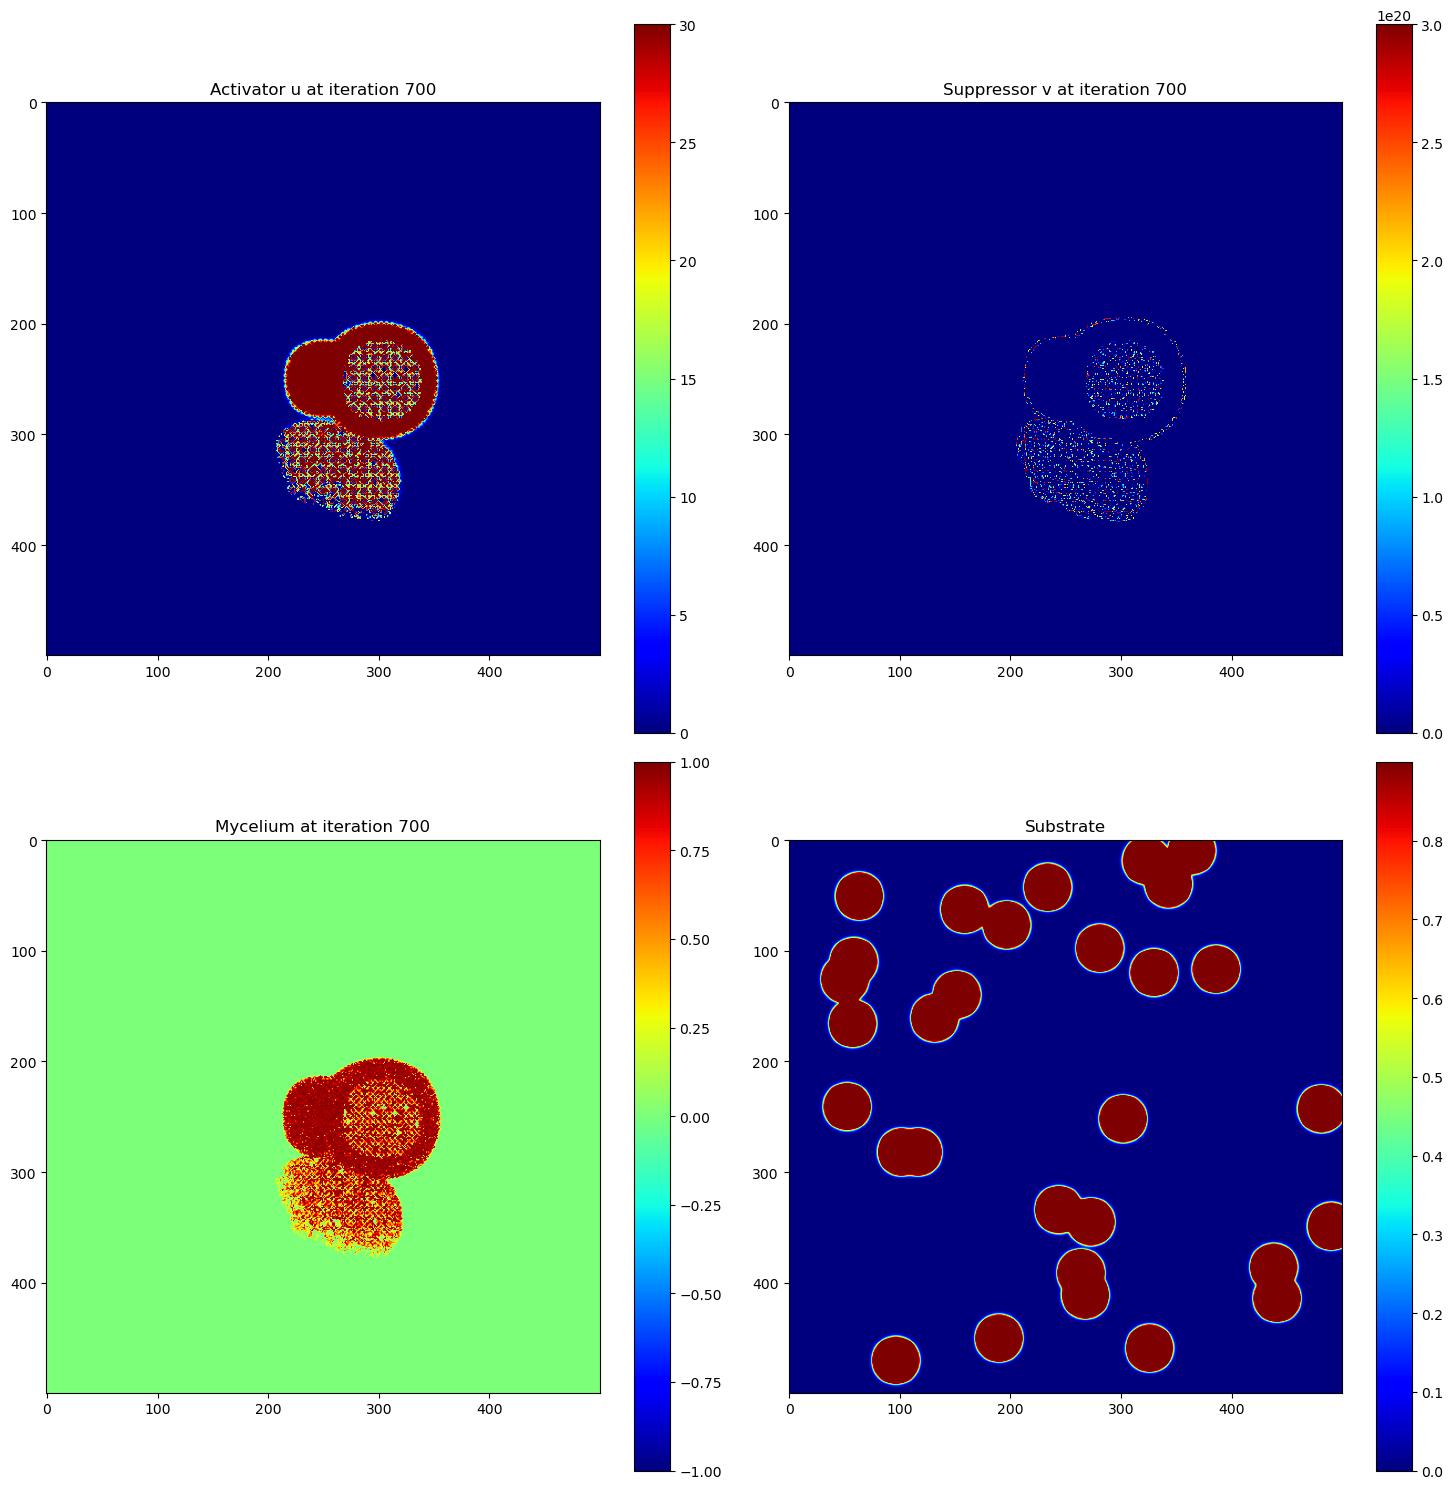

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\c_step_800.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\u_step_800.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\v_step_800.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\n_step_800.csv using NumPy with double precision.


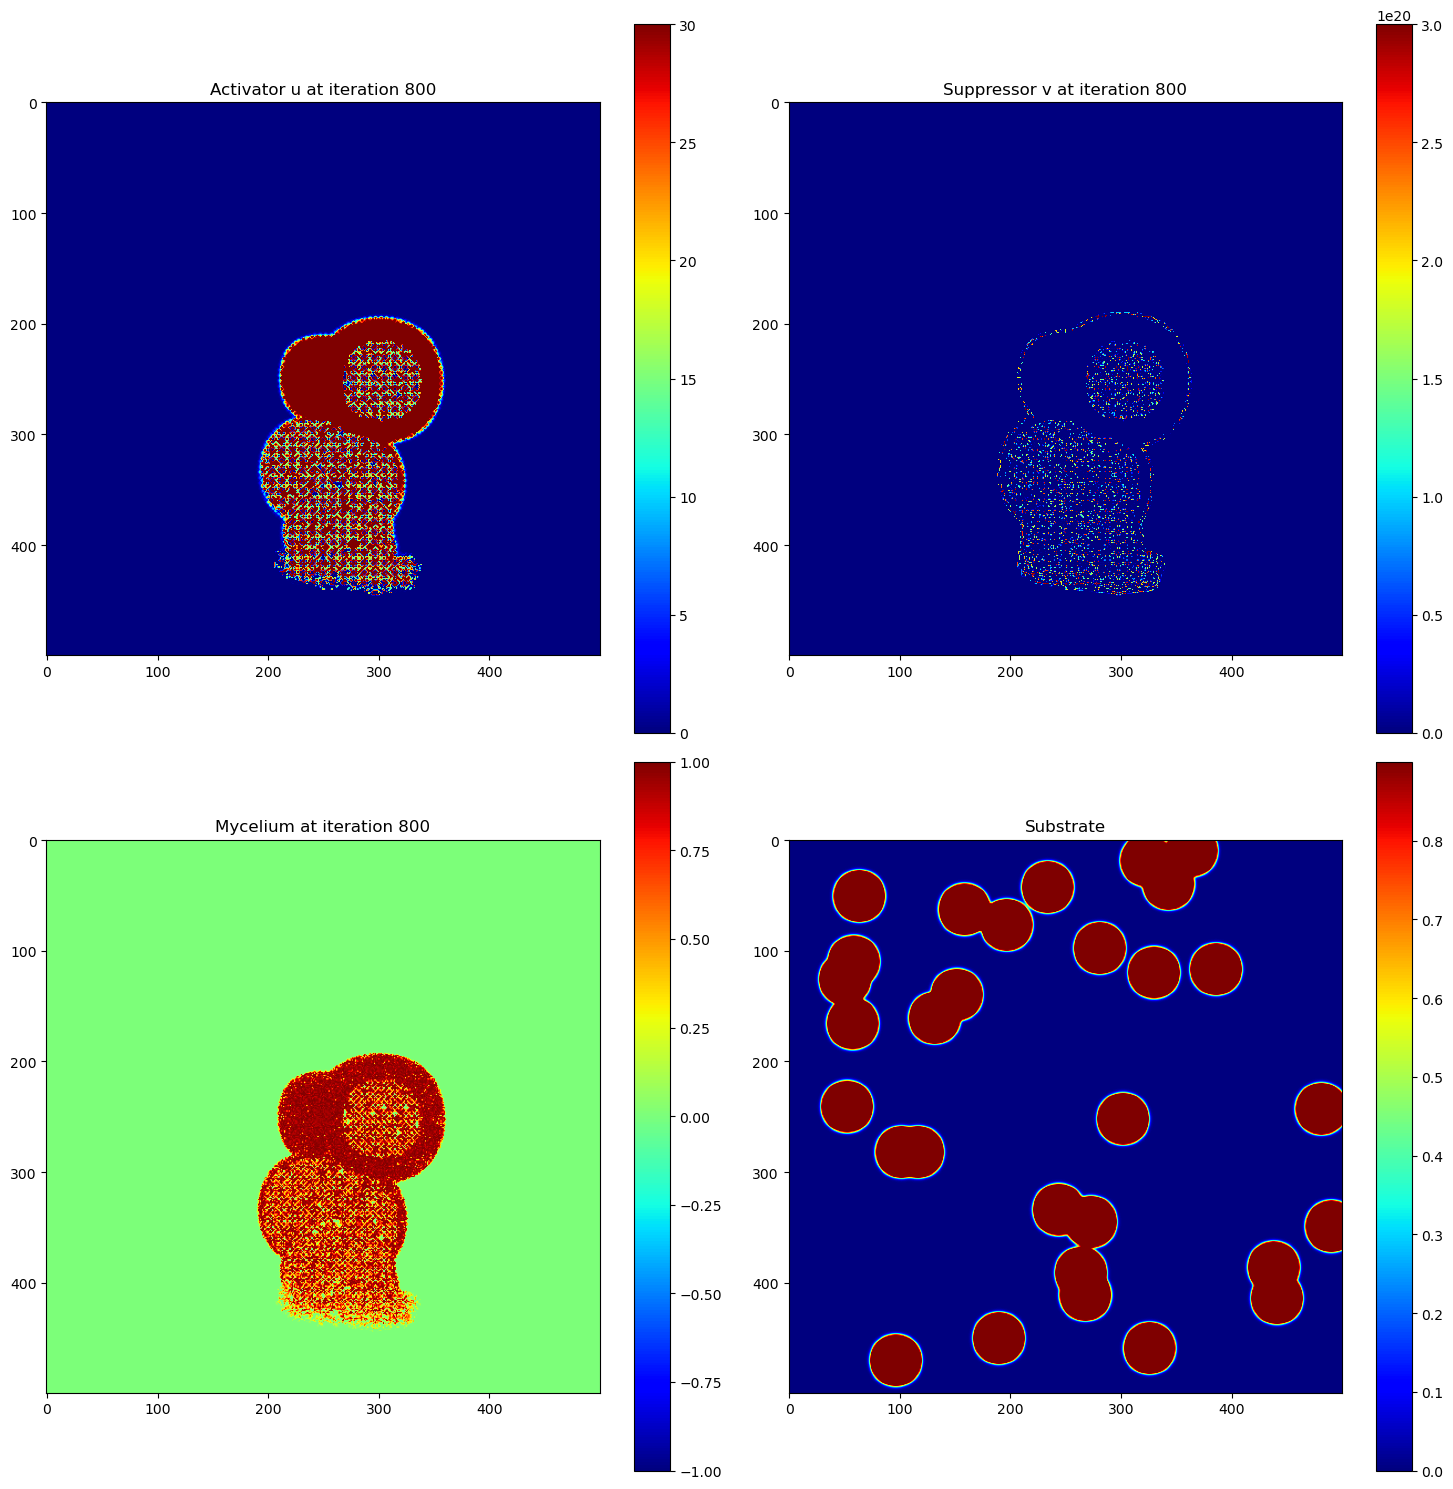

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\c_step_900.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\u_step_900.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\v_step_900.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\n_step_900.csv using NumPy with double precision.


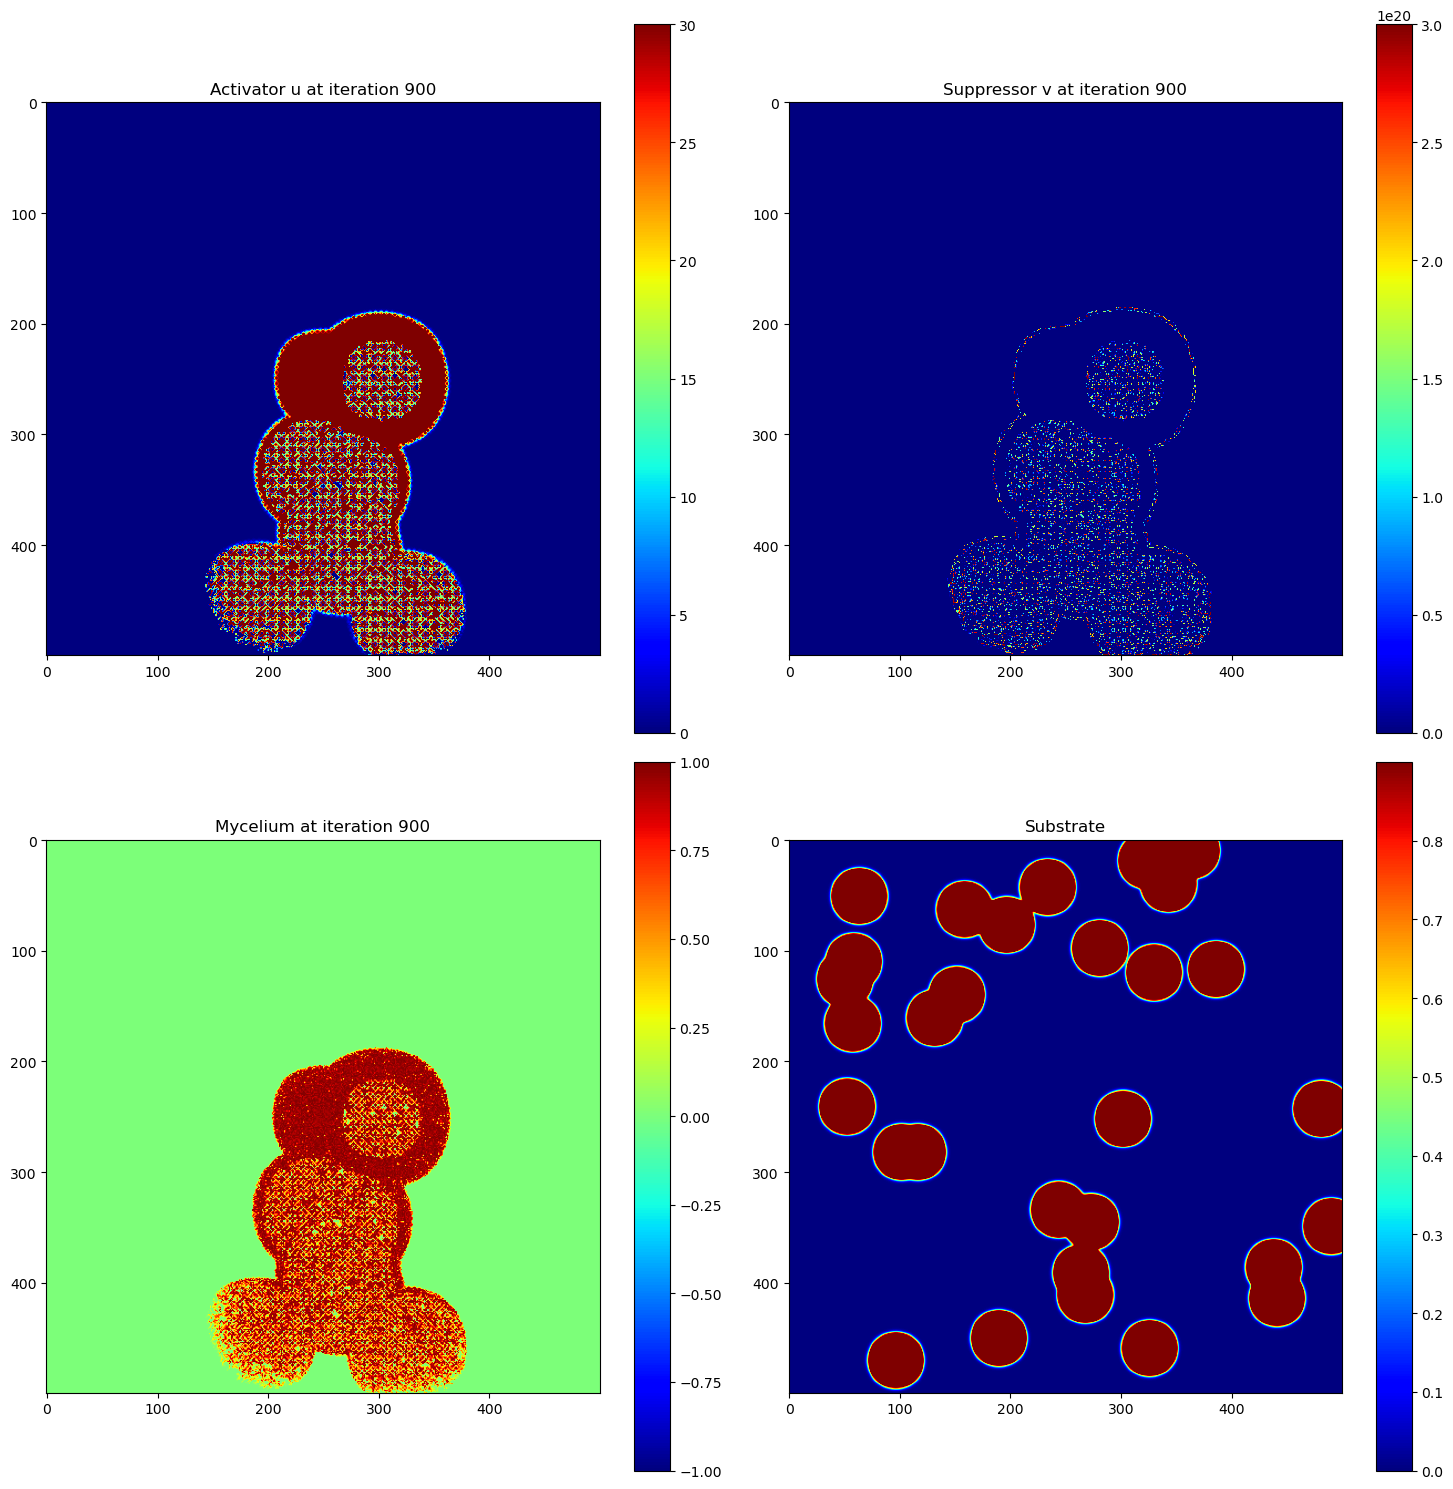

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\c_step_1000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\u_step_1000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\v_step_1000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\DummyOutputs\n_step_1000.csv using NumPy with double precision.


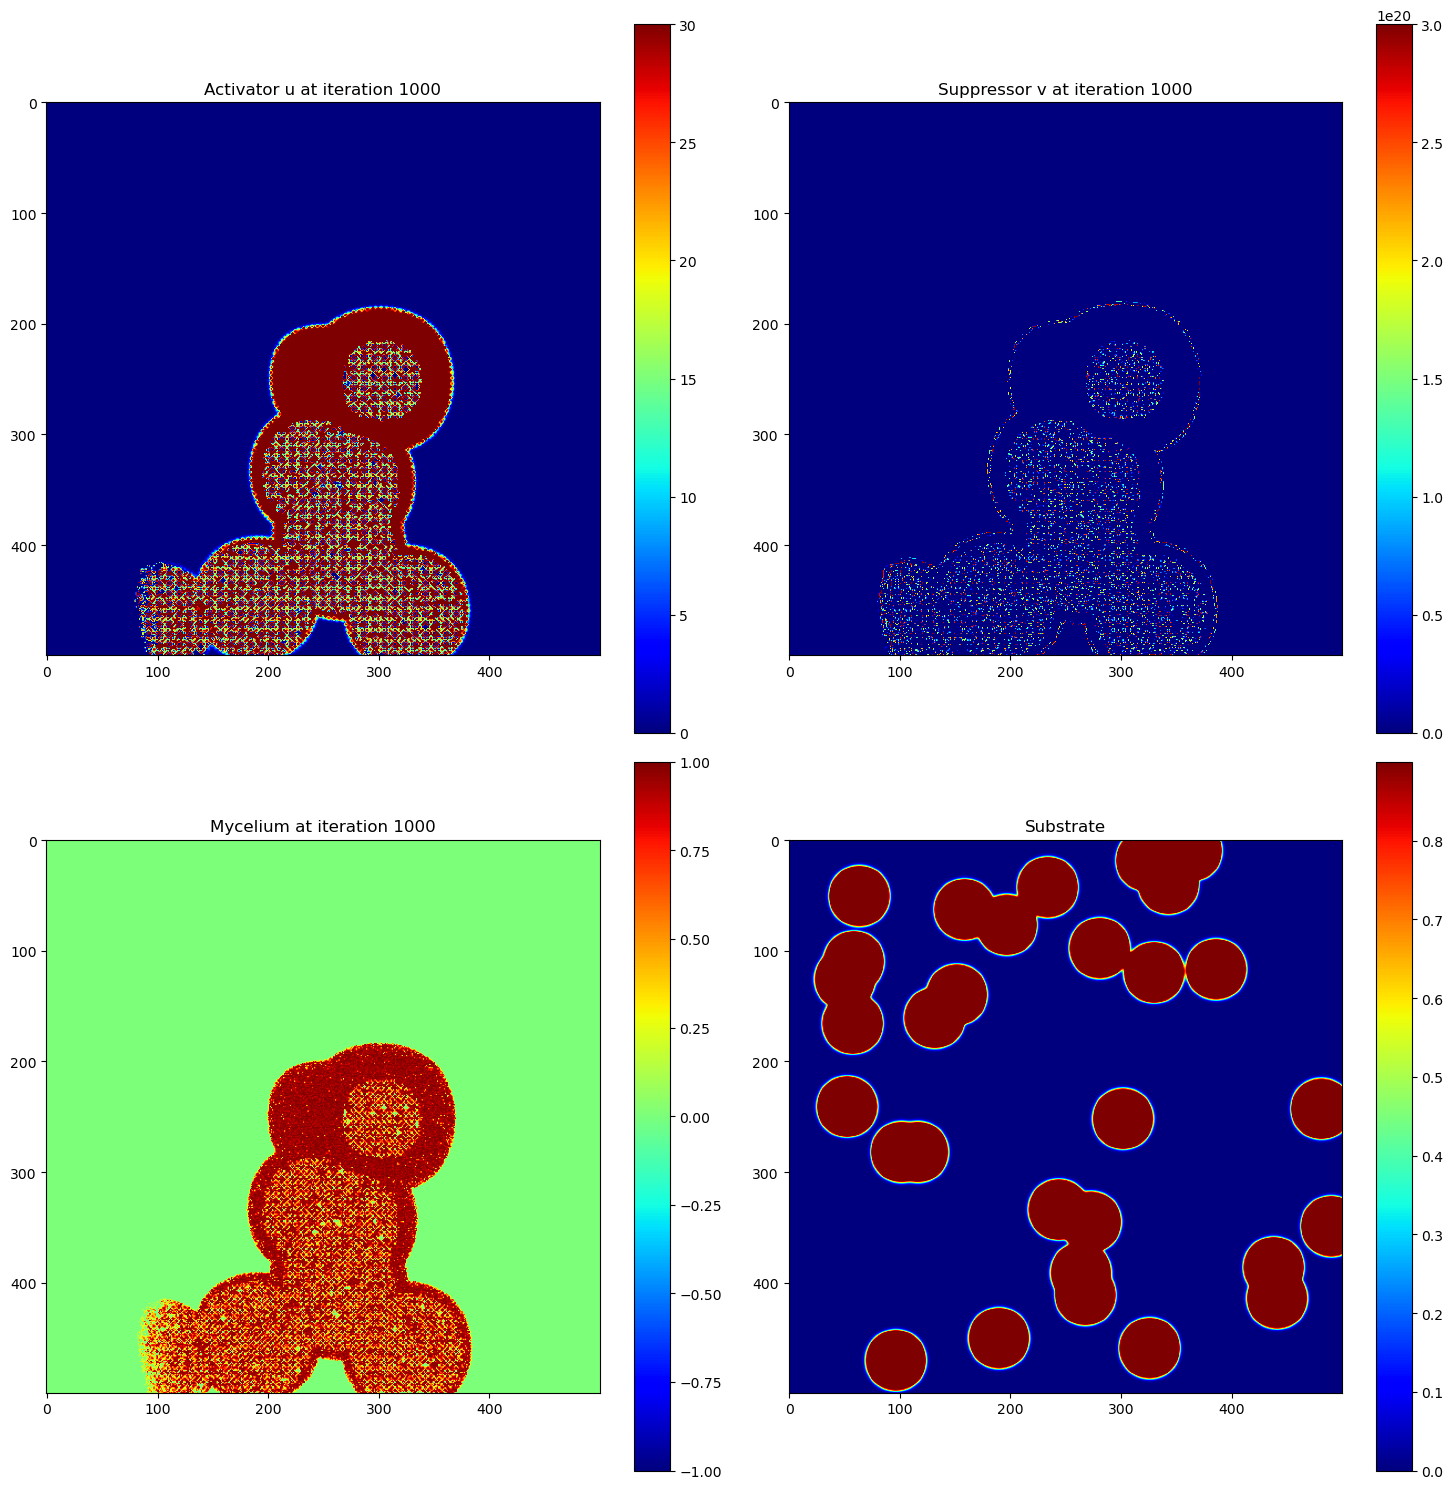

In [85]:
u1, v1, c1, n1 = CA_simulation(u, v, c, n, params, 1000, grid_size, output_dir)

In [71]:
torch.max(v1)

tensor(3.0000e+20, device='cuda:0')